In [0]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__) 

1.13.1


In [0]:
url1 = 'https://raw.githubusercontent.com/Mshire130/Ml-datasets/master/train.csv'
train_df = pd.read_csv(url1)
url2 ='https://raw.githubusercontent.com/Mshire130/Ml-datasets/master/test.csv'
test_df = pd.read_csv(url2) 

train_df.head() 



,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984


In [0]:
train_df.isna().sum() #one value thats NaN for y in Dataset 
train_df = train_df.dropna() #removing NaN 

In [0]:
test_df.isna().sum() #no NaN values for test dataset  

x    0
y    0
dtype: int64

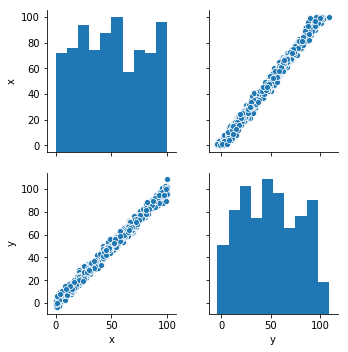

In [0]:
sns.pairplot(train_df[['x','y']]) #plotting valus against eachother, no real use for this datset

In [0]:
#Describing dataset and transposing, so we can access the Mean and SD values for normalisation
train_stats = train_df.describe()
train_stats = train_stats.transpose()
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
x,699.0,50.014306,28.954560,0.000000,25.000000,49.00000,75.000000,100.000000
y,699.0,49.939869,29.109217,-3.839981,24.929968,48.97302,74.929911,108.871618


In [0]:
#separate target values from features, we want to predict y, so pop y 
train_labels = train_df.copy()
train_labels = train_labels.pop('y')
train_labels.head()

test_labels = test_df.copy()
test_labels = test_labels.pop('y')
test_labels.head()


0    79.775152
1    23.177279
2    25.609262
3    17.857388
4    41.849864
Name: y, dtype: float64

In [0]:
#Normalising the data

def norm(x):
  return (x - train_stats['mean'])/train_stats['std']

norm_train_df = norm(train_df)
norm_test_df = norm(test_df)

In [0]:
#Building the model 
#3 layers, 64,64, 1 output. 
#1st layer always define n, activation method and input shape 
#middle layers define n and activation 
#last output layer, define n (1?)
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation = tf.nn.relu, input_shape=[len(train_df.keys())]),
    layers.Dense(64, activation = tf.nn.relu),
    layers.Dense(1)   
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = ['mean_absolute_error', 'mean_squared_error'])
  return model 

In [0]:

model = build_model()

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [0]:
#trial running the model with a small set of train data
example_batch = norm_train_df[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.0062938 ],
       [ 0.00174293],
       [ 0.01048401],
       [ 0.00281804],
       [-0.42720947],
       [ 0.00284583],
       [ 0.0100501 ],
       [-0.35380152],
       [ 0.00677446],
       [ 0.01314457]], dtype=float32)

In [0]:
#Training the model 
#Displaying the training progress by printing dots 

class PrintDot(keras.callbacks.Callback): #need to review OOP
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='') 
    
    
EP0CHS = 1000  

history = model.fit(norm_train_df, train_labels,
                    epochs = EP0CHS, validation_split = 0.2, verbose= 0,
                    callbacks =[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
995,0.043458,0.121089,0.043458,0.790514,0.737032,0.790514
996,0.103682,0.217815,0.103682,0.001793,0.038275,0.001793
997,0.088640,0.156025,0.088640,0.080808,0.233317,0.080808
998,0.133475,0.251555,0.133475,0.003513,0.057031,0.003513
999,0.129926,0.251467,0.129926,0.326519,0.470477,0.326519


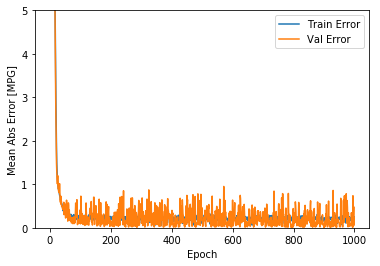

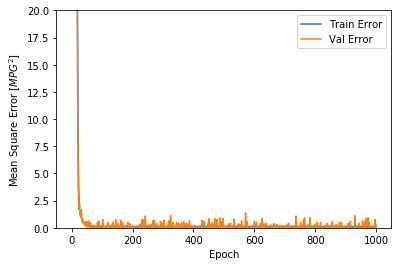

In [0]:


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.......................................................................

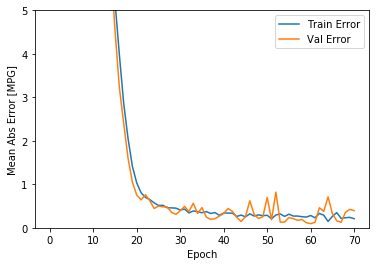

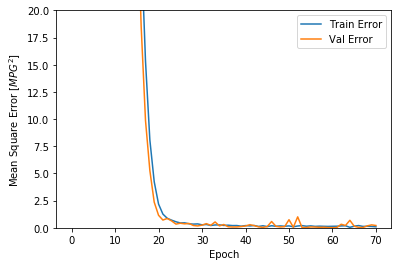

In [0]:
#Doing early stopping to prevent over fitting, (however this situation also has underfitting, not sure how to fix this just yet)
model = build_model()
#Patience parameter tells the model how many epochs to check the loss value 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(norm_train_df, train_labels, epochs=EP0CHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [0]:
loss, mae, mse = model.evaluate(norm_test_df, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

Testing set Mean Abs Error:  0.37 


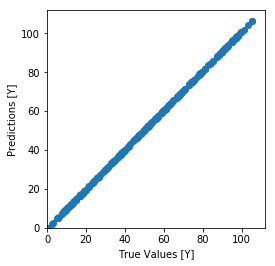

In [0]:
#Running the test data through the model 
test_predictions = model.predict(norm_test_df).flatten() 
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Y]')
plt.ylabel('Predictions [Y]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])